In [1]:
import seaborn as sns
import pandas as pd 
import numpy as np
from scipy.spatial.distance import squareform, pdist
import matplotlib.pyplot as plt
import torch
import anndata as an
import scanpy as sc
import umap
import gc
from importlib import reload

from datasets import Dataset, load_from_disk
from datasets import load_dataset
from geneformer import EmbExtractor
import geneformer

# local imports
import geneformer_utils as gtu

sns.set_style('white')

/home/oliven/miniconda3/envs/geneformer2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [2]:
reload(gtu)
torch.cuda.empty_cache()
num_cells = 1000

"""Load the model"""
model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224/"
# model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer-12L-30M/"
model = gtu.load_model(model_path)

"""Load the data"""
data_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/data/tabula_sapiens_skin.dataset"
df = gtu.load_data_as_dataframe(data_path, num_cells=num_cells, shuffle=True)
df.head()
# convert into arrow dataset
data = Dataset.from_pandas(df)

# useful for later
features = df.columns.to_list()
features.remove("input_ids")

print(f"{df.shape=}")
df.head()

Some weights of BertForMaskedLM were not initialized from the model checkpoint at /nfs/turbo/umms-indikar/shared/projects/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224/ and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


df.shape=(1000, 13)


,input_ids,organ_tissue,method,donor,anatomical_information,n_counts_UMIs,n_genes,cell_ontology_class,free_annotation,manually_annotated,compartment,gender,length
0,"[5592, 2124, 19437, 5950, 10774, 15987, 13326,...",Skin,10X,TSP10,nan,2608.0,1021,muscle cell,muscle cells,True,stromal,male,969
1,"[1867, 690, 3842, 9008, 10057, 5950, 7673, 520...",Skin,smartseq2,TSP10,abdomen,460718.0,1602,"cd4-positive, alpha-beta memory t cell",CD4-positive memory T cell,True,immune,male,1235
2,"[10259, 6179, 3287, 12607, 15169, 1947, 15243,...",Skin,10X,TSP10,nan,5981.0,1830,endothelial cell,endothelial cells,True,endothelial,male,1739
3,"[9227, 16598, 7135, 11054, 13139, 15987, 12172...",Skin,10X,TSP14,Abdomen,11518.0,2391,stromal cell,stromal cells,True,stromal,male,2048
4,"[6961, 5395, 454, 12172, 4552, 1950, 9034, 165...",Skin,10X,TSP14,Chest,5241.0,1999,stromal cell,stromal cells,True,stromal,male,1971


In [3]:
reload(gtu)
embs = gtu.extract_embedding_in_mem(model, data)
print(f"{embs.shape=}")
embs.head()

100%|██████████| 100/100 [00:16<00:00,  6.19it/s]


embs.shape=(1000, 256)


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,2.711090,0.187383,0.239745,0.393539,-0.112276,1.388968,-0.134040,-0.868182,0.232495,-1.920423,...,0.596737,0.314359,-0.386577,1.025249,-1.249049,1.129708,0.126806,-0.594753,1.272539,-2.350683
1,2.755697,-0.622036,0.151965,0.163109,0.059213,1.144224,0.050582,-0.682027,0.177123,-1.433323,...,1.051344,0.076182,-0.420886,1.013731,-1.016336,1.885732,0.584950,-0.531569,1.188760,-1.748696
2,2.905659,-0.063184,0.229211,0.246834,-0.001422,1.383184,0.048251,-0.918938,0.363960,-1.894448,...,0.883817,0.381345,-0.386347,1.080776,-1.243107,1.591713,0.364978,-0.501669,1.213874,-2.184385
3,2.978120,-0.016917,0.233690,0.214388,-0.039725,1.347737,0.135381,-0.768237,0.287111,-1.696364,...,0.991157,0.257335,-0.481338,1.027107,-1.087105,1.728167,0.567194,-0.504296,1.193364,-1.975128
4,2.821826,0.130746,0.217291,0.309881,-0.145327,1.381229,0.063782,-0.780526,0.347385,-1.719223,...,0.927267,0.430447,-0.464131,0.983897,-1.189527,1.435029,0.499385,-0.488563,1.137273,-1.965396


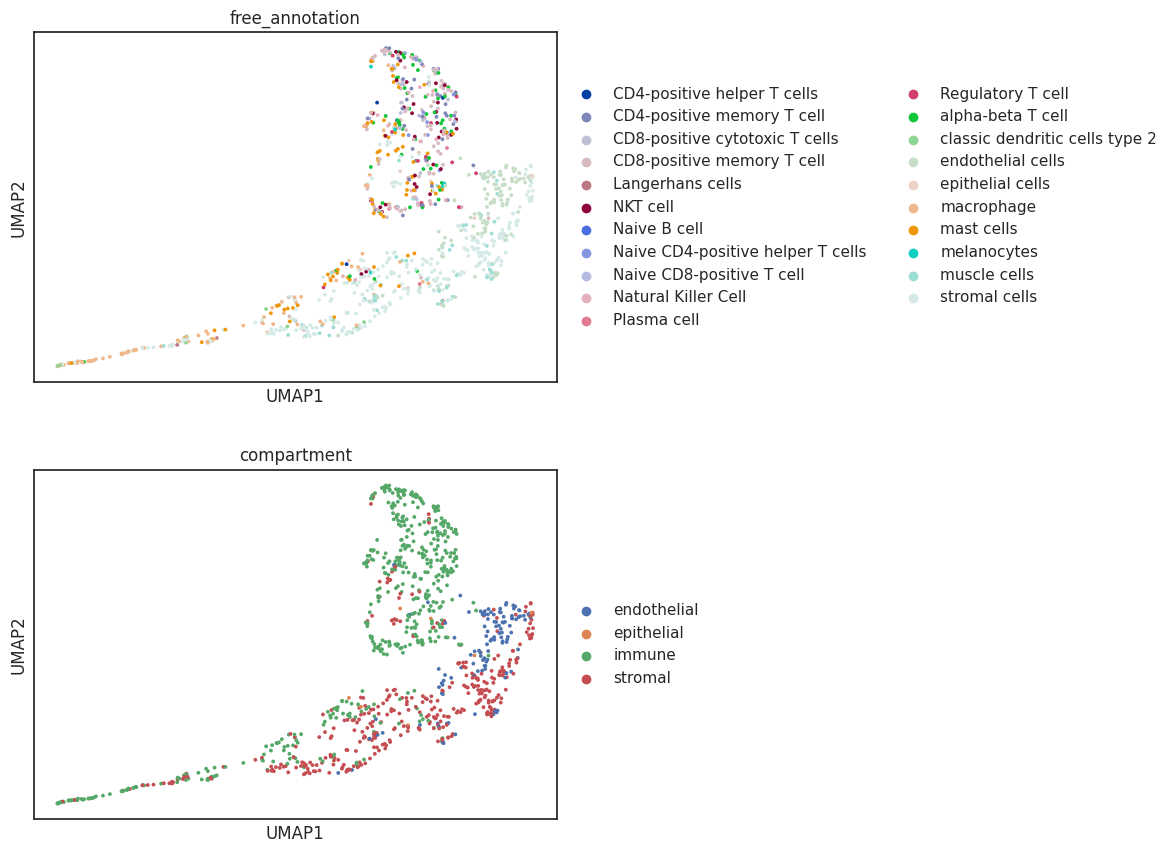

AnnData object with n_obs × n_vars = 1000 × 256
    obs: 'input_ids', 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'length'
    uns: 'pca', 'neighbors', 'umap', 'free_annotation_colors', 'compartment_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [4]:
# translate into an anndata object and plot
adata = gtu.embedding_to_adata(embs)
adata.obs = df.copy()

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(
    adata,
    color=["free_annotation", "compartment"],
    ncols=1,
    size=30,
)

adata

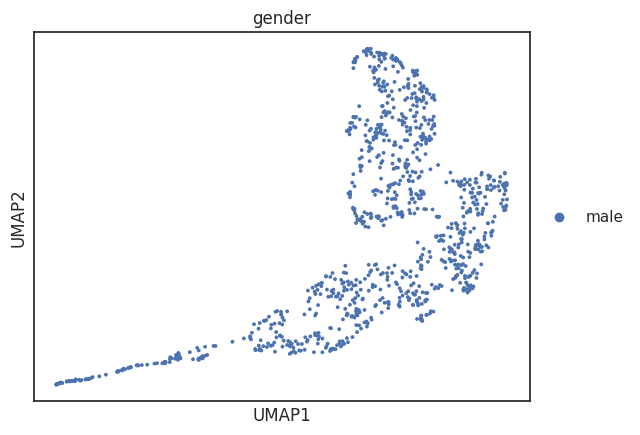

In [5]:
sc.pl.umap(
    adata,
    color=["gender"],
    ncols=1,
    size=30,
)

In [6]:
reload(gtu)
torch.cuda.empty_cache()

"""Load the data"""
data_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/data/tabula_sapiens_skin.dataset"
df = gtu.load_data_as_dataframe(data_path)
df = df[df['free_annotation'] == "skeletal muscle cells"]
print(f"{df.shape=}")
data = Dataset.from_pandas(df)

# gene embedding
gene_embedding = gtu.extract_embedding_in_mem(model, data, emb_mode='gene')
print(f"{gene_embedding.shape=}")

# cell embedding
cell_embedding = gtu.extract_embedding_in_mem(model, data, emb_mode='cell')
print(f"{cell_embedding.shape=}")

df.shape=(10, 13)


100%|██████████| 1/1 [00:00<00:00, 11.09it/s]


gene_embedding.shape=(10, 2048, 256)


100%|██████████| 1/1 [00:00<00:00, 11.79it/s]

cell_embedding.shape=(10, 256)


# Test cell embedding anf gene embedding

In [7]:
cell_embedding.to_numpy()[0, 0:3]

array([ 2.972943  , -0.19370112,  0.1437098 ], dtype=float32)

In [8]:
test = gene_embedding.mean(axis=1)
test[0, 0:3]

array([ 2.972941  , -0.19370115,  0.1437097 ], dtype=float32)

In [9]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
### More Tabula Sapiens 7/2

In [41]:
reload(gtu)
torch.cuda.empty_cache()
num_cells = 1000

"""Load the model"""
model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224/"
# model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer-12L-30M/"
model = gtu.load_model(model_path)

"""Load the data"""
data_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/datasets/TS_Vasculature.dataset"
df = gtu.load_data_as_dataframe(data_path, num_cells=num_cells, shuffle=True)
df.head()
# # convert into arrow dataset
# data = Dataset.from_pandas(df)

# # useful for later
# features = df.columns.to_list()
# features.remove("input_ids")

# print(f"{df.shape=}")
# df.head()
df["cell_ontology_class"]
df["free_annotation"]

# just me making sure that cell_ontology_class and free_annotation are equal (they are)
#faster way?
for index, row in df.loc[:, ['cell_ontology_class', 'free_annotation']].iterrows():
    if (row['cell_ontology_class'] != row['free_annotation']):
        print("unequal")
print("done!")


Some weights of BertForMaskedLM were not initialized from the model checkpoint at /nfs/turbo/umms-indikar/shared/projects/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224/ and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


done!


In [28]:
reload(gtu)
embs = gtu.extract_embedding_in_mem(model, data)
print(f"{embs.shape=}")
#embs.head()
embs.shape

100%|██████████| 1/1 [00:00<00:00, 11.16it/s]

embs.shape=(10, 256)


(10, 256)

In [43]:
# Define a search function
def search_string(s, search):
    return search in str(s).lower()

mask = df.apply(lambda x: x.map(lambda s: search_string(s, 'fibroblast')))

filtered_df = df.loc[mask.any(axis=1)]

print(filtered_df)
filtered_df.shape


                                             input_ids organ_tissue  \
0    [16345, 9009, 13048, 6489, 10292, 9508, 12698,...  Vasculature   
1    [12119, 9190, 16876, 3396, 8654, 5298, 4692, 1...  Vasculature   
4    [3878, 9009, 4115, 1950, 376, 16281, 16916, 14...  Vasculature   
6    [3878, 16916, 18367, 9009, 1950, 12119, 16876,...  Vasculature   
7    [6196, 16916, 10920, 11828, 8133, 16166, 8163,...  Vasculature   
..                                                 ...          ...   
984  [12119, 18367, 16876, 9123, 303, 6541, 10057, ...  Vasculature   
985  [376, 3878, 12119, 5592, 15960, 16916, 16281, ...  Vasculature   
988  [9009, 12119, 16916, 8658, 16876, 3878, 15960,...  Vasculature   
996  [2649, 5592, 2124, 16166, 7414, 376, 454, 220,...  Vasculature   
998  [12119, 4840, 15960, 19437, 2649, 6252, 5080, ...  Vasculature   

        method  donor anatomical_information  n_counts_UMIs  n_genes  \
0          10X  TSP14       CoronaryArteries        12027.0     3428   
1  

(354, 13)

In [46]:
# convert filtered stuff to df
filtered_dataset = Dataset.from_pandas(filtered_df)
filtered_dataset.save_to_disk("/home/oliven/geneformer_dev/notebooks/ts_output")
loaded_dataset = Dataset.load_from_disk("/home/oliven/geneformer_dev/notebooks/ts_output")

Saving the dataset (1/1 shards): 100%|██████████| 354/354 [00:00<00:00, 25202.56 examples/s]


In [ ]:
#### All-in-One Extract Embeddings

In [47]:


# model = "/nfs/turbo/umms-indikar/shared/projects/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224/"
model = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer-12L-30M/"
# data_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/data/rajapakse_lab_data.dataset"
# data_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/data/tabula_sapiens_muscle.dataset"
data_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/datasets/TS_Vasculature.dataset"
outpath = "/home/oliven/geneformer_dev/notebooks/ts_output/"


torch.cuda.empty_cache()

n_cells = 1000
# 0 for last layer, -1 for second to last
layer = -1

# initiate EmbExtractor
embex = EmbExtractor(model_type="Pretrained",
                     num_classes=0,
                     max_ncells=n_cells,
                     emb_mode='cell',
                     emb_layer=layer,
                     emb_label=["cell_type",],
                     forward_batch_size=30,
                     nproc=16,
                      )

# extracts embedding from input data
embs = embex.extract_embs(model,
                          data_path,
                          outpath,
                          "test")

embs.head()

AttributeError: 'Dataset' object has no attribute 'startswith'